# Cat & Dog Classification with Tensorflow

This notebook explores `tensorflow` to classify a dataset of 25,000 dogs & cats images. It will go through the processes of **loading** and **preparing** data, **defining** the model to train data, and **training** the model. 

## Importing Libraries & Loading Data

In [0]:
# Import libaries
!python3 -m pip install tensorflow-gpu==2.0.0 --user
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import os 

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation

In [0]:
!kaggle --version

In [0]:
os.environ['KAGGLE_USERNAME'] = "codingbunnie" # username from the json file
os.environ['KAGGLE_KEY'] = "99c074951b105c3a35dfaa845827d107" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle

In [0]:
!unzip dogs-vs-cats.zip

In [0]:
!unzip train.zip
!unzip test1.zip

In [0]:
# Path to train & test data

train_dir = 'train/'
test_dir = 'test1/'

# All image paths 
train_data_path = [train_dir + file_name for file_name in os.listdir(train_dir)]

In [0]:
os.listdir(train_dir)[:5]

['cat.2286.jpg',
 'cat.5419.jpg',
 'dog.5092.jpg',
 'cat.6455.jpg',
 'dog.8268.jpg']

# Load and Preprocess Data

Our dataset consists of 25,000 images of cats and dogs split equally and in **jpeg** format. 

### To prepare this dataset for training, let's <font color = red > load </font> images from previously generated <font color = red> image paths, </font> then apply <font color = red> processing </font> on them.

To process the images, let's apply a few functions from the ```tensorflow``` ```image``` module.

1. **[tf.image.decode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/decode_image?version=stable)**

```
    tf.io.decode_image(
    contents,
    channels=None,
    dtype=tf.dtypes.uint8,
    name=None,
    expand_animations=True
    )
```

From the module ```tf.image```, the ```decode_jpeg``` function decodes a **JPEG-encoded image to a uint8 tensor**. In our implementation, we input the arguments ```image``` as ```contents``` and ```channels``` with the value **3** which indicates the number of color channels for the decoded image.  

2. **[tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize?version=stable)**


```
    tf.image.resize(
    images,
    size,
    method=ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=False,
    name=None
    )
```

From the same module, we employ ```resize``` which per its name - ```resizes``` images to a specific ```size``` using the specified ```method```. With the model <font color = blue> **Xceptions** </font>, the input image size required is **299** by **299**. 
The ```method``` defaults to ```bilinear```. 

If images was 3-D, a 3-D float Tensor of shape **[new_height, new_width, channels].** 


3. <font color = blue> [```normalization```](https://medium.com/@dataakkadian/standardization-vs-normalization-da7a3a308c64) </font>

Lastly, we **divide** the image by **255** to normalize the image to range **0** to **1**. Data normalization is an important step which ensures that **each input parameter** (pixel, in this case) has a similar data distribution </font>. This makes **convergence** faster while training the network.

To load the images from their paths, let's use [```read_file```](https://www.tensorflow.org/api_docs/python/tf/io/read_file?version=stable) from the tensorflow ```io``` module which reads and outputs the entire contents of the input filename.

```
    tf.io.read_file(
    filename,
    name=None
    )
    
```

In [0]:
IMAGE_SIZE = 299

'''
FIRST, WE DEFINE A FUCNTION 
WHERE APPLY TENSORFLOW FUNCTIONS 
ARE APPLIED TO PROCESS RAW IMAGES.
'''

def preprocess_image(image):
    
    #decode image into tensors
    image = tf.image.decode_jpeg(image, channels = 3) 
    
    #resize image to fit with Xception's required input
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE]) 
    
    #normalize pixels to range (0, 1)
    image /= 255.0 

    #return preprocessed images
    return image

'''
NOW, LET'S DEFINE A FUNCTION TO LOAD IMAGES FROM IMAGE PATHS, 
APPLY PREPROCESSING 
AND RETURN PREPROCESSED IMAGES. 
'''

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

### Next, let's employ another one of  ```tensorflow``` modules - ```data```. 

With the help of ```tf.data.Dataset.from_tensor_slices( )``` method, we can get the slices of an array in the form of objects. Let's pass the variable <font color = blue> **train_data_path** </font> (type: **list**) defined earlier into the ```from_tensor_slices( )``` function to produce tensors containing individual image paths, saved in the variable <font color = blue> **dataset** </font>. Lastly, we use ```map``` (similar to ```pandas.apply```) to apply the function (`load_and_preprocess_image`) defined earlier onto the <font color = blue> **dataset** </font>.


In [0]:
''' 
FROM IMAGE PATHS (train_data_path), 
SLICE individual path
'''
path_dataset = tf.data.Dataset.from_tensor_slices(train_data_path)

# Create image dataset from path dataset
image_dataset = path_dataset.map(load_and_preprocess_image)

In [0]:
train_data_path[:5]

['train/cat.2286.jpg',
 'train/cat.5419.jpg',
 'train/dog.5092.jpg',
 'train/cat.6455.jpg',
 'train/dog.8268.jpg']

In [0]:
print(type(train_data_path))
print(type(path_dataset))
print(type(image_dataset))

<class 'list'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


### Our dataset is 'labelled' such that the name of the file contains <font color = grey> 'dog' </font> or <font color = gray> 'cat' </font> . Let's write some codes to teach the computer these labels. 

1. We assign 1 to file name containing 'cat', 0 for file name containing 'dog'. Let's save this in ```image_label```. 
2. Using ```tf.cast```, we change ```image_label``` datatype to int64 before applying ```from_tensor_slices``` on the labels and save it in another variable called ```label_dataset```.

In [0]:
'''
WE ASSIGN THE IMAGE LABEL WITH 1 IF ITS FILE NAME CONTAINS 'CAT'
BINARILY, FILE NAMES CONTAINING 'DOG' WILL BE ASSIGNED WITH 0.
'''

image_label = list(map(lambda x: 1 if 'cat' in x else 0, os.listdir(train_dir)))

'''
NEXT, WE USE TF.CAST TO CHANGE THE DATA TYPE TO INT64 BEFORE SLICING.
'''
label_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(image_label, tf.int64))

### Before splitting up the dataset into three separate sets <font color = gray> Training, Validation & Testing </font>, let's <font color = red> zip </font> the images and their respective labels together.

In [0]:
# Combine image dataset and image label dataset

dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

In [0]:
# Let's take a look at our dataset :) 
dataset

# We can observe that it contains the images of dimensions 224 x 224 x 3 and a label (0 or 1). 
# Let's proceed to splitting the data up for training. 

<ZipDataset shapes: ((299, 299, 3), ()), types: (tf.float32, tf.int64)>

## Split
### Train : Validation : Test = 70 : 15 : 15. 

To split, we initilize by determining the ```dataset_size``` (25,000), ```batch_size``` (128) and ```shuffle_buffer_size``` (4096). 

#### Train Set

- to get the 70% of data for the train set, we define ```train_size``` to be 70% of ```dataset_size```. 
- next, we apply ```shuffle``` to ```tf.data.Dataset.zip((image_dataset, label_dataset))``` or our earlier defined ```dataset``` using ```shuffle_buffer_size``` of 4096. This will split the dataset into batches of **4096** images, then shuffling each batch before placing them back into the population. The smaller the ```shuffle_buffer_size```, the more randomized the population will end up. 
- then, the `train_dataset` will be defined by applying `take` using the `train_size` (70% * 25,000). `take` will grab the first 70% of the images after shuffling. 

#### Test Set & Validation Set

- first, we apply the function `skip` to the variable `dataset` with the argument `train_size`, which will skip the first 70% of the image population and save it to `test_dataset`.
- then, on `test_dataset`, we apply `skip` again, this time by `val_size` (15%), and save it to `val_dataset`. This means `val_dataset` will contain the last 15% of the population.
- lastly, on `test_dataset` again, we apply `take` with the argument `test_size`. This effectively grab the first 15% of the remaining 30% as the `test_dataset`. 

Please see code below for clearer understanding.

In [0]:
DATASET_SIZE = 25000
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 4096

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

dataset = dataset.shuffle(buffer_size = SHUFFLE_BUFFER_SIZE)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

### Let's perform mini-batching onto the <font color = gray> train_dataset</font> & <font color = gray> test_dataset </font>  then save them again.

In [0]:
# Perform mini-batch in train_dataset and test_dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, 
                                                                 drop_remainder = True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder = True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder = True)

# Building the Model.

In this notebook, we employ a pretrained model `Xception`. [Xception](https://www.mathworks.com/help/deeplearning/ref/xception.html) is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 71 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. 

As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 299-by-299.

The idea is that we will make use of the huge dataset trained by Xception (luckily, two of the 1000 objects are dogs and cats) which in turn would help us vastly improve our accuracy. 
We will only utilize trainable layers in `Xception` - that is, those that are applicable to our Cat / Dog classifier and we ensure this by deploying `pretrained_model.trainable` = `False` in our function. We also add new classfier layers as seen in the code below. 

For the **optimizer**, we will use `RMSprop`. For this we pass in two arguments: `lr` for learning rate and `momentum` as 0.9 - a standard figure - to capture the cumulative effect of gradient descent. 

For the **loss** function, we deploy `binary_crossentropy` as our output layer uses `sigmoid`.

In [0]:
# Define model
def define_model():
    # load model
    pretrained_model = tf.keras.applications.Xception(include_top = False, input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # mark pretrained layers as not trainable
    pretrained_model.trainable = False
    
    # add new classifier layers
    model = tf.keras.Sequential([pretrained_model,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'),
                                 tf.keras.layers.Dense(1, activation = 'sigmoid')])
    
    optimizer = tf.keras.optimizers.RMSprop(lr = 0.001, momentum = 0.9)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

model = define_model()

#### Callbacks 

Callbacks are utilities called at certain points during training. In this notebook, we employ two callbacks: 

1. `ReduceLROnPlateau` to reduce the `learning rate` by a `factor` of **0.1** if **val_loss** does not improve after **3** `epochs`. (`patience` = 3). The `min_lr` specifies the minimum learning rate to be *0.00001*. `verbose` simply shows the progress. 

2. `ModelCheckpoint` with the param `save_best_only` = `True` will saves the model in the file `checkpoint.h5` at the epoch with the best results (accuracy, val_loss, val_accuracy). 

In [0]:
# Callbacks
161
callbacks = [ReduceLROnPlateau(factor = 0.1, patience = 3, min_lr = 0.00001, verbose = 1),
             ModelCheckpoint('checkpoint.h5', verbose = 1, save_best_only = True)]

In [0]:
# Train model
model_history = model.fit(train_dataset, 
                          epochs = 10, 
                          validation_data = val_dataset, 
                          callbacks = callbacks)

Epoch 1/10
    136/Unknown - 325s 2s/step - loss: 4.6720 - accuracy: 0.9670
Epoch 00001: val_loss improved from inf to 1.77279, saving model to checkpoint.h5
136/136 [==============================] - 421s 3s/step - loss: 4.6720 - accuracy: 0.9670 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
135/136 [============================>.] - ETA: 0s - loss: 0.8223 - accuracy: 0.9858
Epoch 00002: val_loss improved from 1.77279 to 1.50830, saving model to checkpoint.h5
136/136 [==============================] - 156s 1s/step - loss: 0.8222 - accuracy: 0.9859 - val_loss: 1.5083 - val_accuracy: 0.9313
Epoch 3/10
135/136 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9920
Epoch 00003: val_loss improved from 1.50830 to 0.14891, saving model to checkpoint.h5
136/136 [==============================] - 156s 1s/step - loss: 0.0934 - accuracy: 0.9920 - val_loss: 0.1489 - val_accuracy: 0.9790
Epoch 4/10
135/136 [============================>.] - ETA: 0s - loss: 0.02

`
Epoch 3/10
135/136 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9920
Epoch 00003: val_loss improved from 1.50830 to 0.14891, saving model to checkpoint.h5`

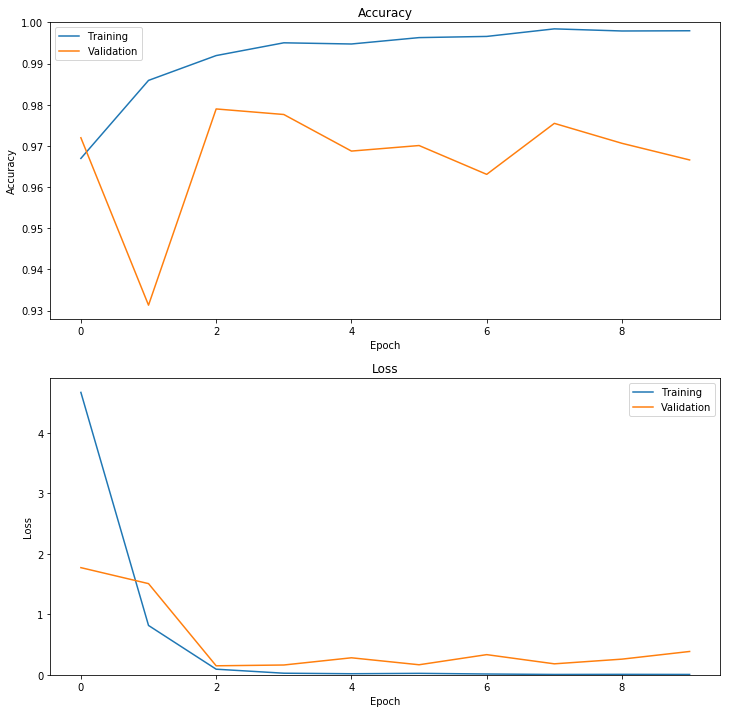

In [0]:
train_accuracy = model_history.history['accuracy']
validation_accuracy = model_history.history['val_accuracy']

train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Training')
plt.plot(validation_accuracy, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Loss')
plt.show()

In [0]:
# Evaluate model
final_model = tf.keras.models.load_model('checkpoint.h5')
final_model.evaluate(test_dataset)

29/29 [==============================] - 58s 2s/step - loss: 0.0921 - accuracy: 0.9820


[0.09205814447767775, 0.9819504]